In [1]:
import sys
sys.path.append('..')
from bias_detection.bias_tree import BiasDetectionTree
from bias_detection.metric import get_metric_bias_tree_for_model
import numpy as np
from sklearn.model_selection import ParameterGrid
from data_preparation.movielens import MovieLens100KData, MovieLens1MData
from data_preparation.marketing_bias import MarketBiasModCloth, MarketBiasElectronics
from data_preparation.book_crossing import BookCrossingData
from data_preparation.deskdrop import DeskdropData
from recommender.surprise_recommender import random_search_fit_surprise_recommendation_model, fit_surprise_recommendation_model
import pandas as pd
import json
import surprise
from matplotlib import pyplot as plt
import random

### Train CF models and tune their hyperparameters

In [ ]:
random.seed(1234)

N_ITER = 10
METRIC = 'absolute'
ALPHA = 0.01
min_user_interactions = 5
min_item_interactions = 10
MAX_DEPTH = 3

leaf_metrics_models = []
avg_metric = []

MODEL_GRID = [ (surprise.SlopeOne, {}),
              (surprise.SVD, {'biased': [True, False], 'n_factors': [10, 50, 100],
                              'n_epochs': [10, 20, 50],
                              'reg_all': [0.01,  0.1],
                              'lr_all': [0.001, 0.01],}),
             (surprise.NMF, {'n_factors': [ 10, 20, 50], 'n_epochs': [10, 20, 50]}), 
             (surprise.CoClustering, {'n_cltr_u': [3, 5, 10], 'n_cltr_i': [3, 5, 10, 10]}),
             (surprise.KNNWithMeans,  {'sim_options':  {'user_based': [True, False]}, 'k':[10, 20, 50],})]
             

datasets = [MarketBiasModCloth('../data/market-bias', min_user_interactions=min_user_interactions, min_item_interactions=min_item_interactions),
            MarketBiasElectronics('../data/market-bias', min_user_interactions=min_user_interactions, min_item_interactions=min_item_interactions),
            MovieLens100KData(data_path='../data/ml-100k', min_user_interactions=min_user_interactions, min_item_interactions=min_item_interactions), 
            MovieLens1MData('../data/ml-1M', min_user_interactions=min_user_interactions, min_item_interactions=min_item_interactions),
            BookCrossingData(data_path='../data/book-crossing', min_user_interactions=min_user_interactions, min_item_interactions=min_item_interactions),
            DeskdropData(data_path='../data/Deskdrop', min_user_interactions=min_user_interactions, min_item_interactions=min_item_interactions),]

for data in datasets:
    print(data.NAME)
    X_train, X_test = data.get_data_splits_for_training(use_val_set=False)
    MIN_CHILD_NODE_SIZE = round(X_train.shape[0] / 100)
    print("Min node size: ", MIN_CHILD_NODE_SIZE)
    for model_cls, grid in MODEL_GRID:
        print('-----------------')
        print(model_cls.__name__)
        model = random_search_fit_surprise_recommendation_model(X_train, model_cls, grid, n_iter=N_ITER,
                                                                user_col=data.USER_ID_COL_TRANSFORMED, 
                                                                item_col=data.ITEM_ID_COL_TRANSFORMED, 
                                                               rating_col=data.RATING_COL)
        bias_tree = get_metric_bias_tree_for_model(model, X_test, data.attributes_dict, 
                                                     metric_name=METRIC,
                                                    min_child_node_size=MIN_CHILD_NODE_SIZE, alpha=ALPHA,
                                                    user_col=data.USER_ID_COL_TRANSFORMED, 
                                                    item_col=data.ITEM_ID_COL_TRANSFORMED, 
                                                    rating_col=data.RATING_COL, max_depth=MAX_DEPTH)
        model_leaf_metrics = bias_tree.leaf_metrics
        model_leaf_metrics['model'] = model_cls.__name__
        model_leaf_metrics['dataset'] = data.NAME
        model_leaf_metrics['bias_detector'] = 'bias_tree'
        leaf_metrics_models.append(model_leaf_metrics)
      
        avg_metric_model = {}
        avg_metric_model['model'] = model_cls.__name__
        avg_metric_model['dataset'] = data.NAME
        avg_metric_model[METRIC] = X_test[METRIC].mean()
        avg_metric.append(avg_metric_model)
        print("Most biased leaf: ", bias_tree.max_metric_node, round(bias_tree.max_metric_value, 3))
    del X_train
    del X_test

In [3]:
leaf_metrics_models_pd = pd.concat(leaf_metrics_models).replace('KNNWithMeans', 'KNN').replace('KNNBasic', 'KNN').replace('KNNWithZScore', 'KNN')
leaf_metrics_models_pd['node_depth'] = pd.Series(leaf_metrics_models_pd.index).apply(lambda x: len(json.loads(x).keys())).values
leaf_metrics_models_pd

,count,mean,std,min,25%,50%,75%,max,global,model,dataset,bias_detector,node_depth
node_rules,,,,,,,,,,,,,
"{""item popularity_bucketized"": [""(518.0, 909.0]"", ""(909.0, 1887.0]""], ""user activity_bucketized"": [""(42.0, 92.0]"", ""(92.0, 250.0]""], ""size"": [2.0, 4.0, 3.0, 6.0, 8.0]}",558.0,0.735493,0.516210,0.0,0.424627,0.624627,0.923422,3.638954,0.843518,SlopeOne,ModCloth,bias_tree,3
"{""item popularity_bucketized"": [""(518.0, 909.0]"", ""(909.0, 1887.0]""], ""user activity_bucketized"": [""(18.0, 42.0]"", ""(7.0, 18.0]""]}",1255.0,0.767973,0.660788,0.0,0.329100,0.621816,0.992954,3.666467,0.843518,SlopeOne,ModCloth,bias_tree,2
"{""item popularity_bucketized"": [""(518.0, 909.0]"", ""(909.0, 1887.0]""], ""user activity_bucketized"": [""(4.0, 7.0]""]}",756.0,0.788449,0.731228,0.0,0.223500,0.621081,1.132620,4.000000,0.843518,SlopeOne,ModCloth,bias_tree,2
"{""item popularity_bucketized"": [""(261.0, 518.0]"", ""(84.0, 261.0]""], ""user activity_bucketized"": [""(18.0, 42.0]"", ""(42.0, 92.0]"", ""(7.0, 18.0]"", ""(92.0, 250.0]""], ""size"": ["""", 4.0, 1.0, 2.0, 8.0]}",1687.0,0.810611,0.646341,0.0,0.363414,0.671925,1.080421,3.770852,0.843518,SlopeOne,ModCloth,bias_tree,3
"{""item popularity_bucketized"": [""(518.0, 909.0]"", ""(909.0, 1887.0]""], ""user activity_bucketized"": [""(42.0, 92.0]"", ""(92.0, 250.0]""], ""size"": ["""", 1.0, 5.0, 7.0]}",539.0,0.819070,0.653413,0.0,0.398575,0.695613,1.014241,3.782275,0.843518,SlopeOne,ModCloth,bias_tree,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"{""country"": [""Country:Brazil"", ""Country:United States"", ""country:unpopular""], ""item popularity_bucketized"": [""(112.0, 433.0]"", ""(58.0, 112.0]""], ""host"": [""URL:googlediscovery.com"", ""URL:medium.freecodecamp.com"", ""URL:www.linkedin.com"", ""URL:startupi.com.br"", ""host:unpopular""]}",3177.0,0.352119,0.517555,0.0,0.065039,0.218857,0.440885,4.000000,0.490014,KNN,Deskdrop,bias_tree,3
"{""country"": [""Country:Brazil"", ""Country:United States"", ""country:unpopular""], ""item popularity_bucketized"": [""(9.0, 23.0]""], ""lang"": [""en""]}",1675.0,0.368150,0.561780,0.0,0.000000,0.179226,0.512182,4.000000,0.490014,KNN,Deskdrop,bias_tree,3
"{""country"": [""""], ""lang"": [""lang:unpopular"", ""pt""]}",986.0,0.943210,1.065212,0.0,0.146185,0.643261,1.000000,4.000000,0.490014,KNN,Deskdrop,bias_tree,2


### Summarize bias node results 

In [16]:
avg_metric_pd = pd.DataFrame(avg_metric).replace('KNNWithMeans', 'KNN').replace('KNNBasic', 'KNN').replace('KNNWithZScore', 'KNN')\
                .groupby(['dataset', 'model']).mean()
results_bias_detector_global = avg_metric_pd.merge(leaf_metrics_models_pd, on=['model', 'dataset'])\
                        .groupby(['dataset', 'model', 'bias_detector', METRIC])['mean'].describe()[['count', 'min','max']].reset_index(-1)

print(results_bias_detector_global.round(3).to_latex())

\begin{tabular}{lllrrrr}
\toprule
            &          &           &  absolute &  count &    min &    max \\
dataset & model & bias\_detector &           &        &        &        \\
\midrule
BookCrossing & CoClustering & bias\_tree &     1.292 &    7.0 &  1.097 &  1.468 \\
            & KNN & bias\_tree &     1.295 &    9.0 &  1.092 &  1.447 \\
            & NMF & bias\_tree &     1.437 &    3.0 &  1.359 &  1.502 \\
            & SVD & bias\_tree &     1.217 &    5.0 &  1.074 &  1.338 \\
            & SlopeOne & bias\_tree &     1.395 &    8.0 &  1.117 &  1.507 \\
Deskdrop & CoClustering & bias\_tree &     0.500 &    7.0 &  0.260 &  1.007 \\
            & KNN & bias\_tree &     0.490 &    8.0 &  0.262 &  1.196 \\
            & NMF & bias\_tree &     0.521 &    8.0 &  0.280 &  1.017 \\
            & SVD & bias\_tree &     0.496 &    6.0 &  0.285 &  1.026 \\
            & SlopeOne & bias\_tree &     0.529 &    7.0 &  0.260 &  1.035 \\
Electronics & CoClustering & bias\_tree &     0.8

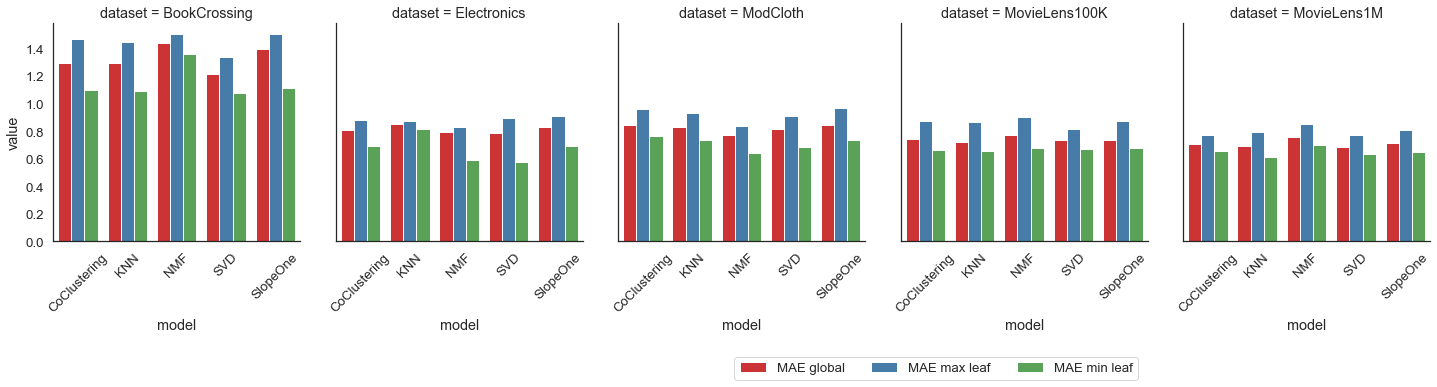

In [17]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set(font_scale=1.2)
sns.set_palette('Set1')
sns.set_style('white')
leaf_metrics_models_pd = leaf_metrics_models_pd.replace('KNNWithMeans', 'KNN').replace('KNNBasic', 'KNN').replace('KNNWithZScore', 'KNN')

test_fair_metrics = pd.melt(results_bias_detector_global.reset_index()[results_bias_detector_global.reset_index()['bias_detector']=='bias_tree'],
                            ['dataset', 'model'], [METRIC, 'max', 'min']).replace(METRIC, 'MAE global').replace('max', 'MAE max leaf').replace('min', 'MAE min leaf')
test_fair_metrics = test_fair_metrics[test_fair_metrics['dataset']!="Deskdrop"]

g = sns.catplot(x="model", y="value",
                hue="variable", col="dataset",
                data=test_fair_metrics, kind="bar",
                height=4,);
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
g._legend.remove()
plt.legend(loc='upper center', bbox_to_anchor=(-1,-0.5), ncol=3)

### Select  model with fairness objective

In [19]:
alpha_fairness = []
results_bias_detector_global['total_unfairness'] = results_bias_detector_global['max'] - results_bias_detector_global['min']
for alpha in np.arange(0, 1.1, .1):
    mae_fair = ((1-alpha) * results_bias_detector_global[METRIC] \
                + alpha * results_bias_detector_global['max']).reset_index()
    mae_fair['alpha'] = alpha
    alpha_fairness.append(mae_fair) 
alpha_fairness_pd = pd.concat(alpha_fairness)
alpha_fairness_pd.columns=['dataset', 'model', "bias_detector", f"$\lambda$-fairness MAE", '$\lambda_{bias}$']
alpha_fairness_pd = alpha_fairness_pd[alpha_fairness_pd['dataset']!="Deskdrop"]

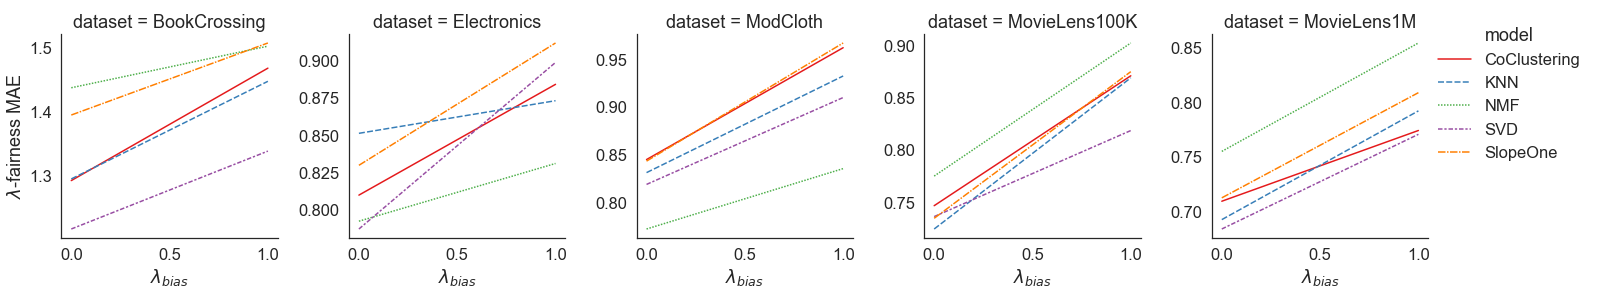

In [35]:
sns.set(font_scale=1.5)
sns.set_palette('Set1')
sns.set_style('white')
g = sns.relplot(
    data=alpha_fairness_pd,
    x="$\lambda_{bias}$", y=f"$\lambda$-fairness MAE",
    hue="model", style="model", col="dataset",
    kind="line", 
    height=4, aspect=1, facet_kws=dict(sharex=False, sharey=False), 
)
leg = g._legend
leg.set_bbox_to_anchor([1, 0.7])  
leg.ncol = 5

plt.savefig(f'global-fairness-coef.png', dpi=100)


In [8]:
results_bias_detector_global['total_unfairness'] = results_bias_detector_global['max'] - results_bias_detector_global['min']

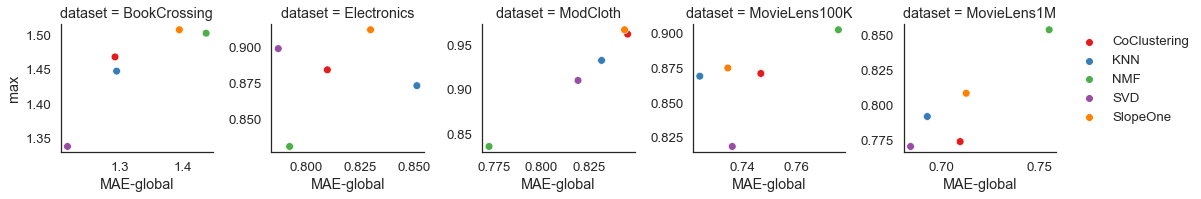

In [38]:
sns.set(font_scale=1.2)
sns.set_palette('Set1')
sns.set_style('white')

results_bias_detector_global = results_bias_detector_global[results_bias_detector_global['dataset']!="Deskdrop"]
g = sns.FacetGrid(results_bias_detector_global[results_bias_detector_global\
                                                             ['bias_detector']=='bias_tree'].rename(columns={METRIC: 'MAE-global'}),
                  col="dataset", sharex=False, sharey=False )
g.map(sns.scatterplot, "MAE-global", "max", 'model', s=60)
plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=[1.5,1], frameon=False)
plt.savefig(f'global-fairness-scatter.png', dpi=100)

In [39]:
best_unfairness = results_bias_detector_global.sort_values('max').groupby(['dataset']).head(1)
best_mae = results_bias_detector_global.sort_values('absolute').groupby(['dataset']).head(1)
best_global_fair = best_mae.merge(best_unfairness, on=['dataset'], suffixes=['_global', '_fair'])[['dataset', 'model_global', 'absolute_global', 'max_global', 'model_fair', 'absolute_fair', 'max_fair']]
best_global_fair['diff_mae'] = 100*(best_global_fair['absolute_global'] - best_global_fair['absolute_fair']) / best_global_fair['absolute_global']
best_global_fair['diff_fairness'] = -100*(best_global_fair['max_global'] - best_global_fair['max_fair']) / best_global_fair['max_global']
print(best_global_fair.round(3).to_latex())

\begin{tabular}{lllrrlrrrr}
\toprule
{} &        dataset & model\_global &  absolute\_global &  max\_global & model\_fair &  absolute\_fair &  max\_fair &  diff\_mae &  diff\_fairness \\
\midrule
0 &    MovieLens1M &          SVD &            0.684 &       0.771 &        SVD &          0.684 &     0.771 &     0.000 &         -0.000 \\
1 &  MovieLens100K &          KNN &            0.725 &       0.869 &        SVD &          0.736 &     0.819 &    -1.636 &         -5.798 \\
2 &       ModCloth &          NMF &            0.772 &       0.836 &        NMF &          0.772 &     0.836 &     0.000 &         -0.000 \\
3 &    Electronics &          SVD &            0.787 &       0.899 &        NMF &          0.793 &     0.831 &    -0.664 &         -7.520 \\
4 &   BookCrossing &          SVD &            1.217 &       1.338 &        SVD &          1.217 &     1.338 &     0.000 &         -0.000 \\
\bottomrule
\end{tabular}

